In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
iggs = [10]
markers = [None,]
color = 'r'
linestyle = '-'

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.color = color
    crdx_igg.marker = marker
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
iggs = [10]
markers = ['D',]
color = 'g'
linestyle = ':'

df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wwfluxg.dat'), 
                 sep=r'\s+')

df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wwcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
    crdxx_igg.type_model = 'crd'
    crdxx_igg.rundir = DIR_XCRD
    crdxx_igg.fpath_flux = s_flux
    crdxx_igg.fpath_coolr = s_coolr
    crdxx_igg.color = color
    crdxx_igg.marker = marker
    crdxx_igg.linestyle = linestyle
    crdxx_igg.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =1e-24

nband = 180

ng =3

ng_refs = (/ 3 /) 

nref =1

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

tsfc =300

vstar = 800

data w_diffuse
     &     /1.66 , 1.66 , 1.85/

data wgt
     &     /0.5 , 0.55 , 0.85/

atmosphere_profiles/trp75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

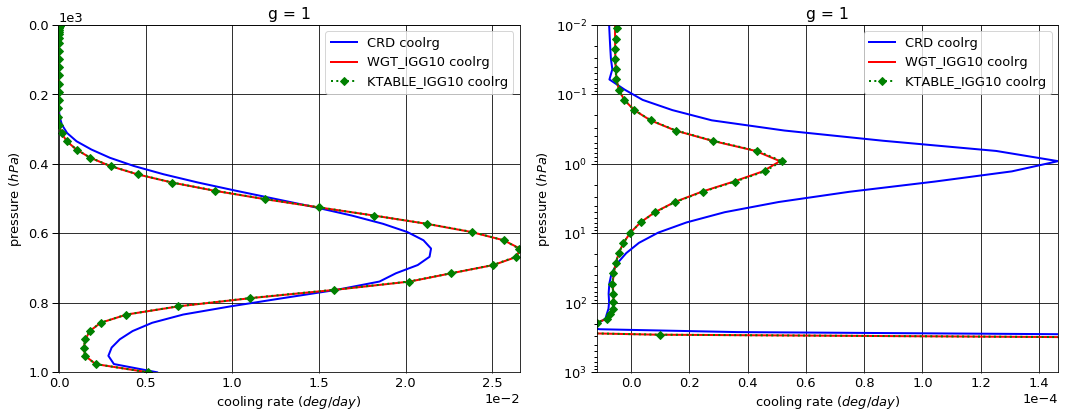

# Figure: cooling rate g-group 2

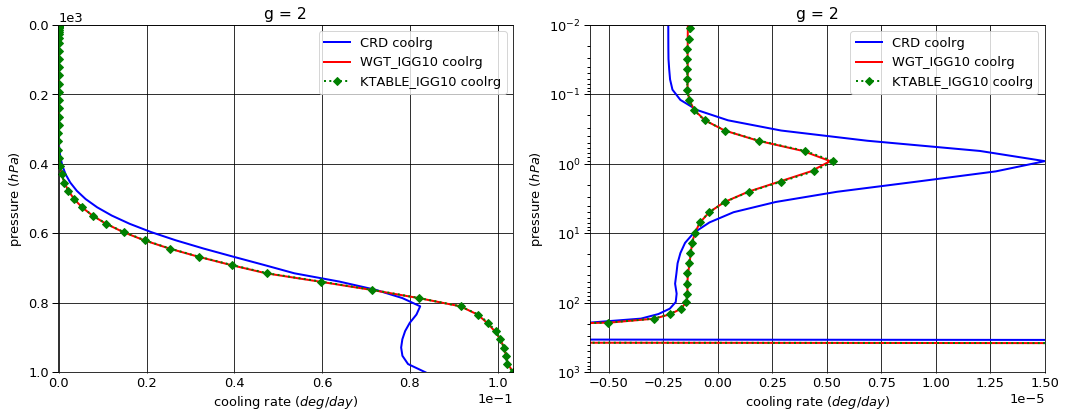

# Figure: cooling rate g-group 3

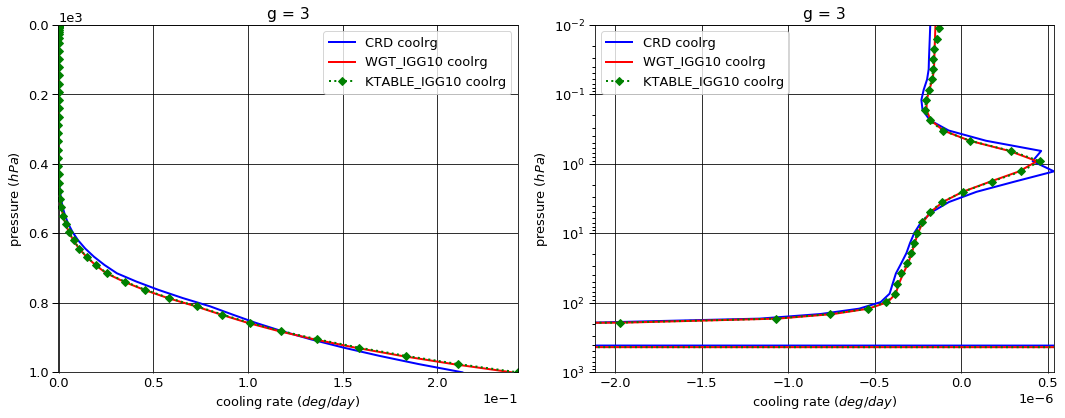

# Figure: cooling rate g-group total

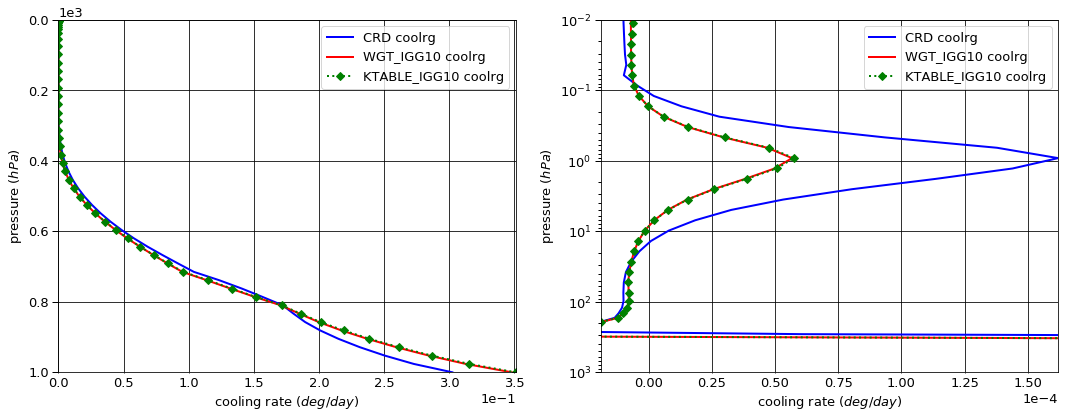

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.911399  0.000000  -0.911399
  1013.0   76     -1.370368  1.344950  -0.025418
2 0.0      1      -4.993151  0.000000  -4.993151
  1013.0   76     -5.794373  4.203143  -1.591230
3 0.0      1     -59.547861  0.000000 -59.547861
  1013.0   76    -60.184709  4.936534 -55.248176


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.909618  0.000000  -0.909618
  1013.0   76     -1.370368  1.352731  -0.017637
2 0.0      1      -5.033480  0.000000  -5.033480
  1013.0   76     -5.794373  4.463092  -1.331280
3 0.0      1     -59.593871  0.000000 -59.593871
  1013.0   76    -60.184709  4.877439 -55.307271


KTABLE_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.909080  0.000000  -0.909080
  1013.0   76     -1.370368  1.352785  -0.017583
2 0.0      1      -5.030278  0.000000  -5.030278
  1013.0   76     -5.794373  4.473685  -1.320688
3 0.0      1     -59.586482  0.000000 -59.586482
  1013.0   76    -60.184709  4.938790 -55.245920


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.001781  0.000000  0.001781
  1013.0   76     0.000000  0.007781  0.007781
2 0.0      1     -0.040330  0.000000 -0.040330
  1013.0   76     0.000000  0.259949  0.259949
3 0.0      1     -0.046010  0.000000 -0.046010
  1013.0   76     0.000000 -0.059095 -0.059095


KTABLE_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.002319  0.000000  0.002319
  1013.0   76     0.000000  0.007835  0.007835
2 0.0      1     -0.037127  0.000000 -0.037127
  1013.0   76     0.000000  0.270542  0.270541
3 0.0      1     -0.038621  0.000000 -0.038621
  1013.0   76     0.000000  0.002256  0.002256

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -8.389248e-06
  1001.112500 75     5.663035e-03
2 0.000312    1     -2.250075e-06
  1001.112500 75     8.354871e-02
3 0.000312    1     -1.592761e-07
  1001.112500 75     2.131548e-01


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -5.517422e-06
  1001.112500 75     5.136766e-03
2 0.000312    1     -1.332064e-06
  1001.112500 75     1.035427e-01
3 0.000312    1     -1.318975e-07
  1001.112500 75     2.392380e-01


KTABLE_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -3.496330e-06
  1001.112500 75     5.130428e-03
2 0.000312    1     -9.659117e-07
  1001.112500 75     1.034233e-01
3 0.000312    1     -6.196206e-08
  1001.112500 75     2.424292e-01


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.871826e-06
  1001.112500 75    -5.262696e-04
2 0.000312    1      9.180112e-07
  1001.112500 75     1.999399e-02
3 0.000312    1      2.737858e-08
  1001.112500 75     2.608314e-02


KTABLE_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      4.892918e-06
  1001.112500 75    -5.326067e-04
2 0.000312    1      1.284164e-06
  1001.112500 75     1.987458e-02
3 0.000312    1      9.731406e-08
  1001.112500 75     2.927436e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-65.452411,0.000000,-65.452411
1013.0,76,-67.349450,10.484627,-56.864823



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-65.53697,0.000000,-65.536970
1013.0,76,-67.34945,10.693262,-56.656189



KTABLE_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-65.52584,0.000000,-65.525840
1013.0,76,-67.34945,10.765259,-56.584191



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.084559,0.000000,-0.084559
1013.0,76,0.000000,0.208635,0.208635



KTABLE_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.073429,0.000000,-0.073429
1013.0,76,0.000000,0.280632,0.280632


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000011
1001.112500,75,0.302367



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000007
1001.112500,75,0.347917



KTABLE_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000005
1001.112500,75,0.350983



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000004
1001.112500,75,0.045551



KTABLE_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000006
1001.112500,75,0.048616


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.019389,0.020953
2,0.084389,0.087107
3,0.896222,0.891940


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.191856e-23
2,1.000925e-24
3,2.367330e-27


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.191856e-23,NaN,0.019389,0.020953,0.019389,0.020953,600.0
2,1.000925e-24,0.083980,0.084389,0.087107,0.103778,0.108060,600.0
3,2.367330e-27,0.002365,0.896222,0.891940,1.000000,1.000000,600.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     1.570719e-23  5.376453e-25  29.214784  5.620180e-10
      2 0.000312     4.909078e-25  1.356834e-26  36.180391  1.910465e-11
      3 0.000312     2.227429e-27  2.460757e-29  90.518043  1.312604e-13
2     1 0.000750     1.585282e-23  5.392301e-25  29.398997  2.284248e-10
      2 0.000750     4.944643e-25  1.361470e-26  36.318406  7.750198e-12
      3 0.000750     2.252706e-27  2.477125e-29  90.940345  5.346941e-14
3     1 0.001052     1.615216e-23  5.422738e-25  29.785987  3.262490e-10
      2 0.001052     5.018062e-25  1.370436e-26  36.616536  1.102817e-11
      3 0.001052     2.304847e-27  2.504722e-29  92.020084  7.671858e-14
4     1 0.001476     1.646130e-23  5.453828e-25  30.183014  4.662526e-10
      2 0.001476     5.094164e-25  1.379550e-26  36.926270  1.570308e-11
      3 0.001476     2.359043e-27  2.534244e-29  93.086654  1.101562e-13
5     1 0.002070     1.677625e-23  5.485317e-25  30.583914  6.661916e-10
      2 0.002070     5.171984e-25  1.388738e-26  37.242316  2.235729e-11
      3 0.002070     2.414626e-27  2.565925e-29  94.103512  1.581408e-13
6     1 0.002904     1.709699e-23  5.517428e-25  30.987245  9.519659e-10
      2 0.002904     5.251529e-25  1.398067e-26  37.562793  3.183791e-11
      3 0.002904     2.471618e-27  2.600608e-29  95.040002  2.270617e-13
7     1 0.004074     1.742355e-23  5.550494e-25  31.390986  1.360352e-09
      2 0.004074     5.332812e-25  1.407631e-26  37.885007  4.534442e-11
      3 0.004074     2.530056e-27  2.639511e-29  95.853206  3.260418e-13
8     1 0.005714     1.775618e-23  5.585013e-25  31.792548  1.943808e-09
      2 0.005714     5.415895e-25  1.417575e-26  38.205347  6.458319e-11
      3 0.005714     2.590018e-27  2.684380e-29  96.484798  4.681656e-13
9     1 0.008015     1.809478e-23  5.621643e-25  32.187702  2.777563e-09
      2 0.008015     5.500744e-25  1.428091e-26  38.518175  9.199539e-11
      3 0.008015     2.651532e-27  2.737659e-29  96.853961  6.722948e-13
10    1 0.011243     1.843947e-23  5.661344e-25  32.570825  3.968882e-09
      2 0.011243     5.587365e-25  1.439457e-26  38.815785  1.310526e-10
      3 0.011243     2.714670e-27  2.802832e-29  96.854539  9.654798e-13
11    1 0.015771     1.879029e-23  5.705461e-25  32.933867  5.671276e-09
      2 0.015771     5.675725e-25  1.452067e-26  39.087204  1.867100e-10
      3 0.015771     2.779511e-27  2.884804e-29  96.350105  1.386656e-12
12    1 0.022122     1.914734e-23  5.755892e-25  33.265630  8.103926e-09
      2 0.022122     5.765774e-25  1.466478e-26  39.317162  2.660230e-10
      3 0.022122     2.846158e-27  2.990468e-29  95.174354  1.991758e-12
13    1 0.031031     1.951190e-23  5.815399e-25  33.552123  1.158103e-08
      2 0.031031     5.857732e-25  1.483498e-26  39.485937  3.790724e-10
      3 0.031031     2.914970e-27  3.129567e-29  93.142914  2.861528e-12
14    1 0.043528     1.998622e-23  5.895863e-25  33.898717  1.663477e-08
      2 0.043528     5.977931e-25  1.506582e-26  39.678755  5.425850e-10
      3 0.043528     3.005362e-27  3.325214e-29  90.381031  4.138595e-12
15    1 0.061057     2.174072e-23  6.091752e-25  35.688783  2.534580e-08
      2 0.061057     6.435341e-25  1.563443e-26  41.161337  8.187336e-10
      3 0.061057     3.343627e-27  3.717832e-29  89.934867  6.458750e-12
16    1 0.085645     2.566763e-23  6.451960e-25  39.782693  4.185657e-08
      2 0.085645     7.504967e-25  1.672793e-26  44.864891  1.337169e-09
      3 0.085645     4.138912e-27  4.467359e-29  92.647843  1.121393e-11
17    1 0.120136     3.113394e-23  6.908908e-25  45.063483  7.101180e-08
      2 0.120136     9.094512e-25  1.826494e-26  49.792168  2.268897e-09
      3 0.120136     5.337318e-27  5.631123e-29  94.782478  2.028356e-11
18    1 0.168516     3.774610e-23  7.454709e-25  50.633900  1.204763e-07
      2 0.168516     1.117020e-24  2.030604e-26  55.009228  3.903025e-09
      3 0.1

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
